## Contact Tracing Preparation <a class="tocSkip">

Prepare datasets to run ContactTracing on cells for paired samples with WGS to analyze differential interactions by growing/shrinking/stable tumors specifically, and for differential interactions according to T cell trajectory over decipher_time. 

Author: Kevin Hoffer-Hawlik

In [2]:
import warnings; warnings.simplefilter(action='ignore',)

In [3]:
warnings.simplefilter(action='ignore',)

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as colormaps
from matplotlib import colors
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import seaborn as sns
import scipy.stats
import pickle
import seaborn as sns
import tqdm.notebook

from scipy import interpolate, ndimage

import decipher as dc
dc.pl.activate_journal_quality()

In [5]:
import importlib
import helper_functions
importlib.reload(helper_functions)

<module 'helper_functions' from '/home/kh3205/melanoma-project/helper_functions.py'>

In [6]:
patients = ['F01','F03','F12','F16','R319','F02','R310'] # last two are R

In [7]:
clinical_outcomes = pd.read_csv("clin_022625.csv")
clinical_outcomes.set_index(keys = 'sample', inplace=True)

# Load and merge datasets

## main integrated dataset for matched patients

In [5]:
adata = sc.read_h5ad('unprocessed/data_melanoma_integrated_RPCA_v4.h5ad')
adata.shape

(305218, 35675)

In [6]:
adata = adata[adata.obs['patient'].isin(patients)]
adata.shape

(115028, 35675)

In [7]:
adata.obs['barcode_sample'] = adata.obs['barcode_orig'] + '_' + adata.obs['sample'] 

In [8]:
len(adata.obs['barcode_sample'].unique())

115028

## interactions, T cell, and myeloid hvgs

running on these HVGs to speed up computation (may expand to global HVGs or other cell type HVGs later)

In [11]:
interactions = pd.read_csv('ContactTracing_interactions.txt', sep='\t',index_col=0)
keep_interactions = set(interactions.index.values) | set(interactions.receptor.values)
len(keep_interactions)

795

In [12]:
tcells = sc.read_h5ad('tcells_scvi_annotated_041924.h5ad')
tcells_genes = set(tcells.var_names)
len(tcells_genes)

8170

In [13]:
# tcells = tcells.raw.to_adata() # to regain full gene expression
# tcells = tcells[tcells.obs['patient'].isin(patients)]
# tcells.shape

In [14]:
myeloids = sc.read_h5ad('myeloid_processed_012224.h5ad')
myeloids_genes = set(myeloids.var_names)
len(myeloids_genes)

2041

In [15]:
# myeloids = myeloids.raw.to_adata() # to regain full gene expression
# myeloids = myeloids[myeloids.obs['patient'].isin(patients)]
# myeloids.shape

## echidna labelled tumor clones

In [16]:
tumor_clones = sc.read_h5ad('echidna_labelled_tumor_ads/all_patients_clones_8.1.24.h5ad')
tumor_clones = tumor_clones[tumor_clones.obs['patient'].isin(patients)]
tumor_clones.shape

(85248, 31213)

In [17]:
tumor_genes = set(tumor_clones.var_names)
len(tumor_genes)

31213

In [18]:
print(len(keep_interactions.difference(tumor_genes)))
print(len(tcells_genes.difference(tumor_genes)))
print(len(myeloids_genes.difference(tumor_genes)))

75
784
180


In [19]:
tumor_clones.obs['barcode'] = tumor_clones.obs.index.astype('str')
tumor_clones.obs['barcode_sample'] = tumor_clones.obs['barcode'] + '_' + tumor_clones.obs['sample'].astype('str')
tumor_clones.obs['barcode_sample'] = tumor_clones.obs['barcode_sample'].astype('category')
tumor_clones.obs.index = tumor_clones.obs['barcode_sample']

In [20]:
clone_mapping = pd.read_csv('echidna_labelled_tumor_ads/echidna_clone_status.8.1.24.csv',index_col=0).T[0]

In [21]:
tumor_clones.obs['leiden'] = tumor_clones.obs['patient'].astype('str') + '_' + tumor_clones.obs['leiden'].astype('str')
tumor_clones.obs['leiden'] = tumor_clones.obs['leiden'].astype('category')
tumor_clones.obs['clone_status'] = tumor_clones.obs['leiden'].replace(clone_mapping)

### filter out for high variance genes

In [22]:
sc.pp.normalize_total(tumor_clones)
sc.pp.log1p(tumor_clones)

In [23]:
hvgs = {}
for patient in tumor_clones.obs['patient'].unique():
    df = tumor_clones[tumor_clones.obs['patient'] == patient,:].to_df()
    var = pd.DataFrame(df.var())
    var_filter = var[var[0]>.01]
    var_filter = set(var_filter.index)
    hvgs[patient] = var_filter
tumor_hvg_list = hvgs[patient] # grab last set to start making union

In [24]:
for patient in hvgs.keys():
    tumor_hvg_list = tumor_hvg_list | hvgs[patient] # union
    # tumor_hvg_list = tumor_hvg_list & hvgs[patient] # intersect
print(len(tumor_hvg_list))

14731


In [41]:
# pd.DataFrame(tumor_hvg_list).to_csv('echidna/tumor_hvgs_080124.csv')

## decipher_time labelled T cells

Need to define 3 buckets or else not enough counts of several CD4 and CD8 buckets

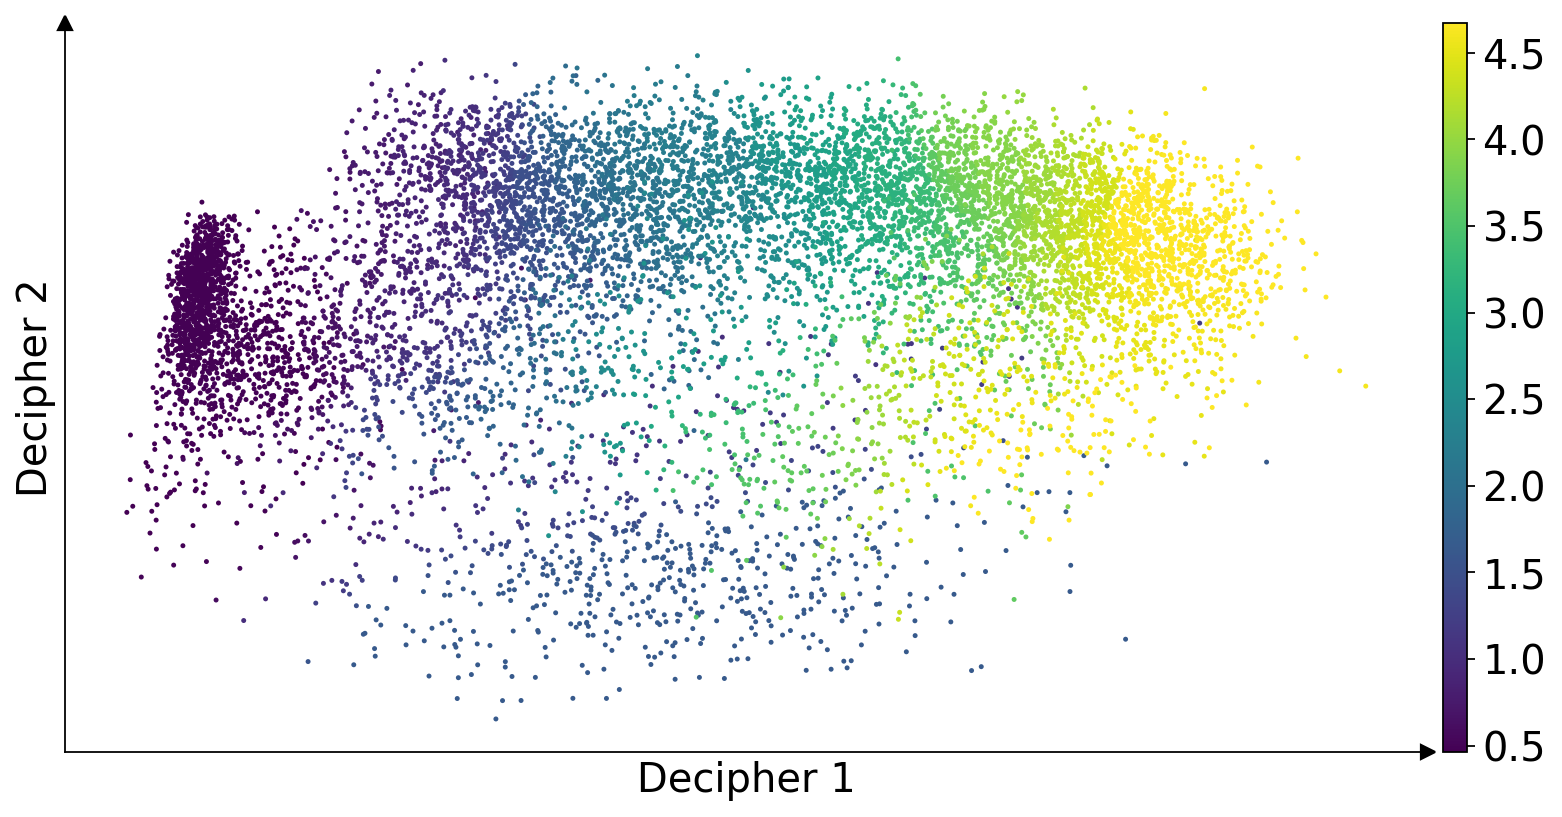

In [6]:
tcells = sc.read_h5ad('tcells_decipher_trajectories_091123.h5ad')

tcells.obs['cell_type_fine'] = tcells.obs['cell_type_khh']
tcells = tcells[tcells.obs['patient'].isin(patients),:]
dc.pl.decipher(tcells, color = 'decipher_time', figsize=(12,6), s=20);

In [ ]:
# calculate correlation between genes and decipher_time for ordering of ligands in output circos plots
gene_corr_dpt = X_df.corrwith(tcells.obs['decipher_time'].astype('float'))
gene_corr_dpt.fillna(0, inplace=True)
gene_corr_dpt

index
MIR1302-2HG    0.000000
AL627309.1    -0.014918
AL627309.3     0.000000
AL627309.2    -0.012354
AL627309.5    -0.035165
                 ...   
AC011509.1     0.000000
DEFB128        0.000000
AL121757.3     0.000000
AL050303.1     0.000000
AL020994.1     0.000000
Length: 35791, dtype: float64

In [56]:
gene_corr_dpt.to_csv('contact_tracing/ContactTracing_tutorial/data/tcell_gene_corr_dpt.csv')

In [61]:
tcells.obs['treated'] = tcells.obs['time'].replace({'on':'Treated','post':'Treated','pre':'Untreated'})

In [26]:
tcells.obs['cell_type_fine'] = tcells.obs['cell_type_fine'].replace({'Naive CD4+ T': 'CD4+ T CM', 'Naive CD8+ T': 'CD8+ T CM'})
tcells.obs['cell_type_fine'].unique()

['CD4+ T', 'Treg', 'CD8+ T CM', 'CD8+ T', 'CD4+ T CM']
Categories (5, object): ['CD4+ T', 'CD8+ T', 'CD4+ T CM', 'CD8+ T CM', 'Treg']

2.1
3.7


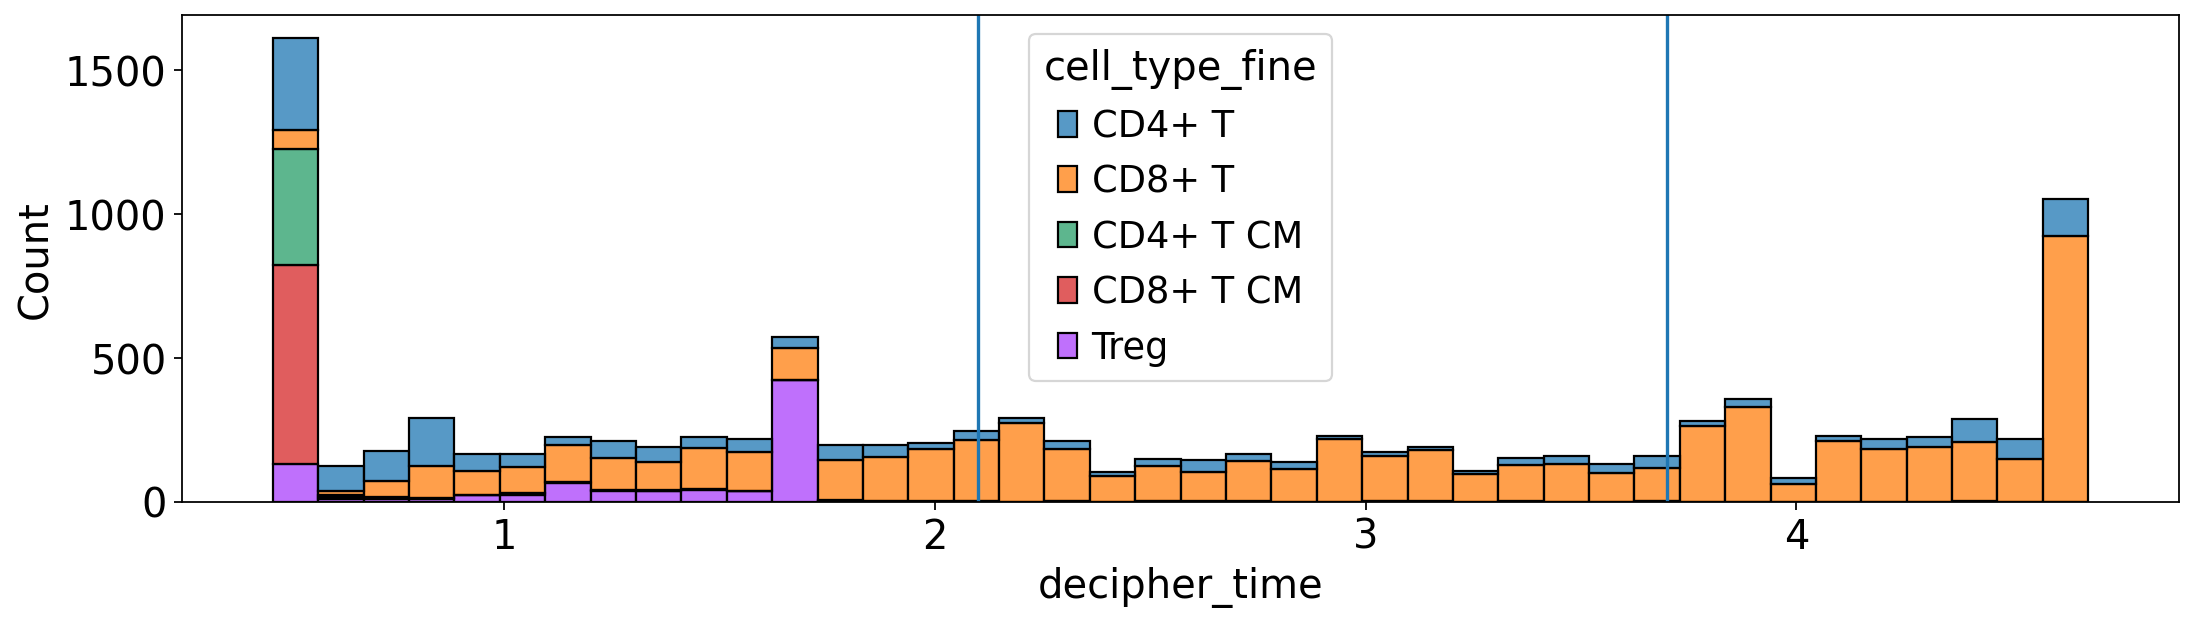

In [27]:
# decide quantiles excluding Tcm and Treg
tcell_quantiles = np.round(np.quantile(tcells[~tcells.obs['cell_type_fine'].isin(['CD8+ T CM','CD4+ T CM','Treg'])].obs.decipher_time.values, [.33,.66]),1)
fig,ax = plt.subplots(figsize=(16,4))
sns.histplot(tcells.obs, x='decipher_time', hue='cell_type_fine', multiple='stack', bins=40);
for quantile in tcell_quantiles:
    print(quantile)
    plt.axvline(quantile, 0, 1200)

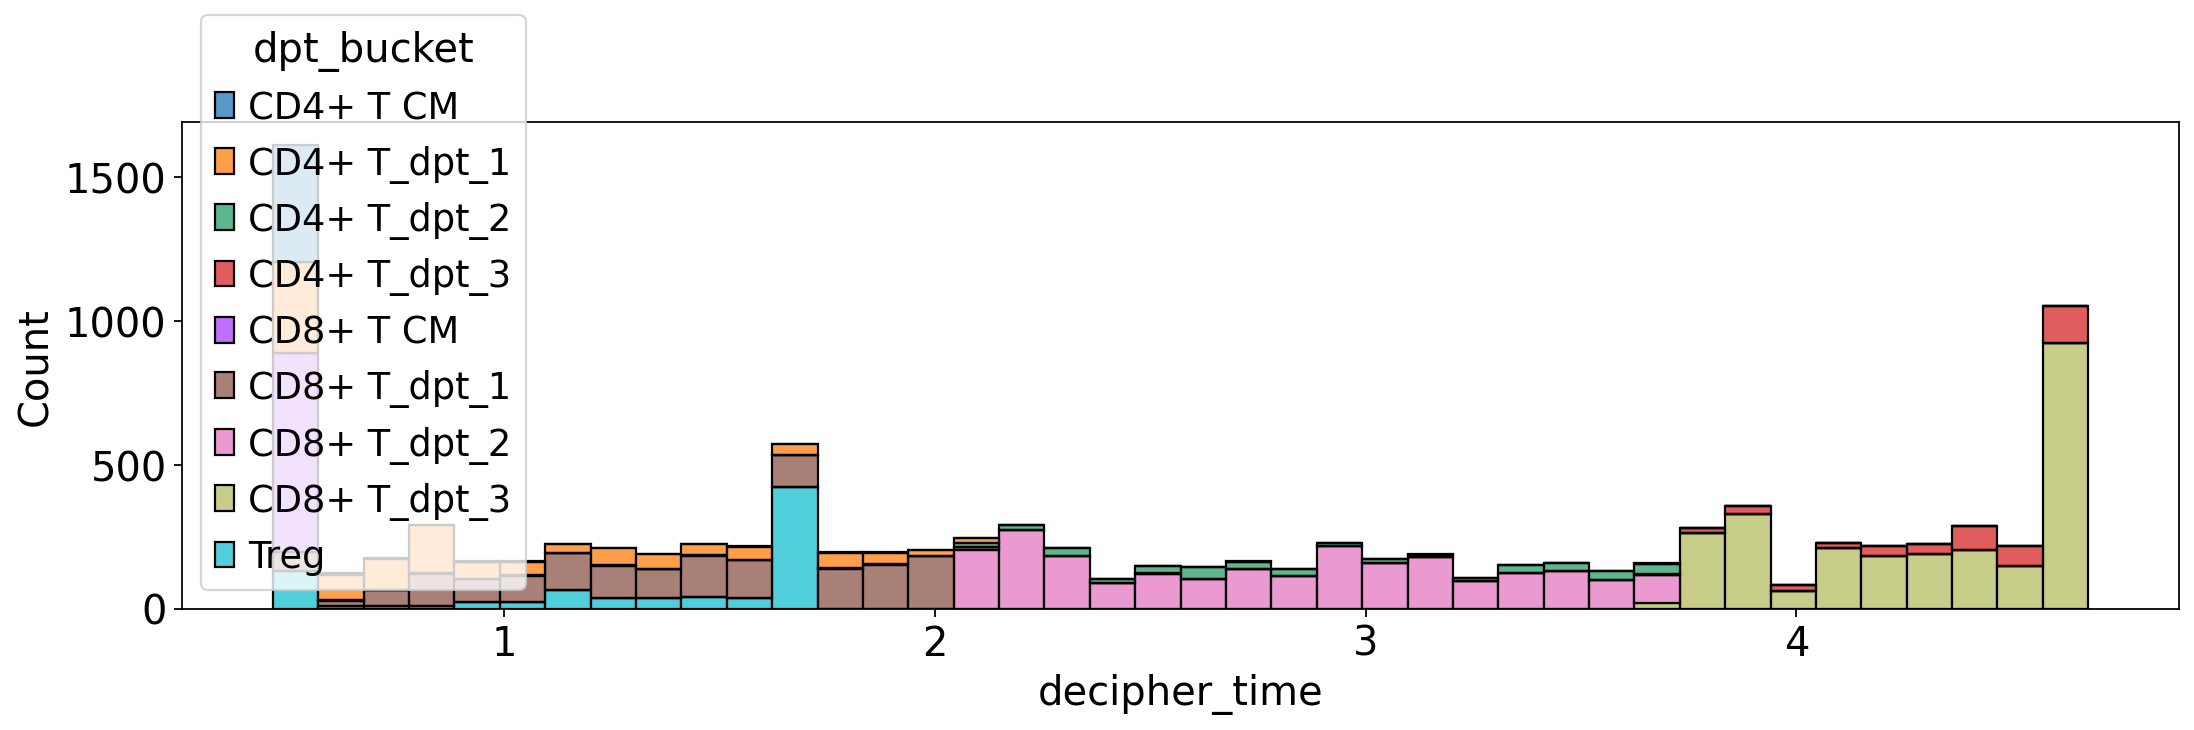

In [ ]:
tcells.obs['dpt_bucket'] = str(1)
tcells.obs.loc[tcells.obs.decipher_time >= tcell_quantiles[0],'dpt_bucket'] = str(2)
tcells.obs.loc[tcells.obs.decipher_time >= tcell_quantiles[1],'dpt_bucket'] = str(3)
tcells.obs['dpt_bucket'] = tcells.obs['cell_type_fine'].astype('str') + '_dpt_' + tcells.obs['dpt_bucket'] # concatenate for CD8 and CD4
tcells.obs.loc[tcells.obs['cell_type_fine'].isin(['CD8+ T CM','CD4+ T CM','Treg']),'dpt_bucket'] = tcells.obs.loc[tcells.obs['cell_type_fine'].isin(['CD8+ T CM','CD4+ T CM','Treg']),'cell_type_fine'] # fix for Tcm and Treg
tcells.obs['dpt_bucket'] = pd.Categorical(tcells.obs['dpt_bucket'], # fix categories
        ['CD4+ T CM', 'CD4+ T_dpt_1','CD4+ T_dpt_2','CD4+ T_dpt_3',
         'CD8+ T CM', 'CD8+ T_dpt_1','CD8+ T_dpt_2','CD8+ T_dpt_3',
         'Treg'])

fig,ax = plt.subplots(figsize=(16,4))
sns.histplot(tcells.obs, x='decipher_time', hue='dpt_bucket', bins=40, multiple='stack', legend=True);

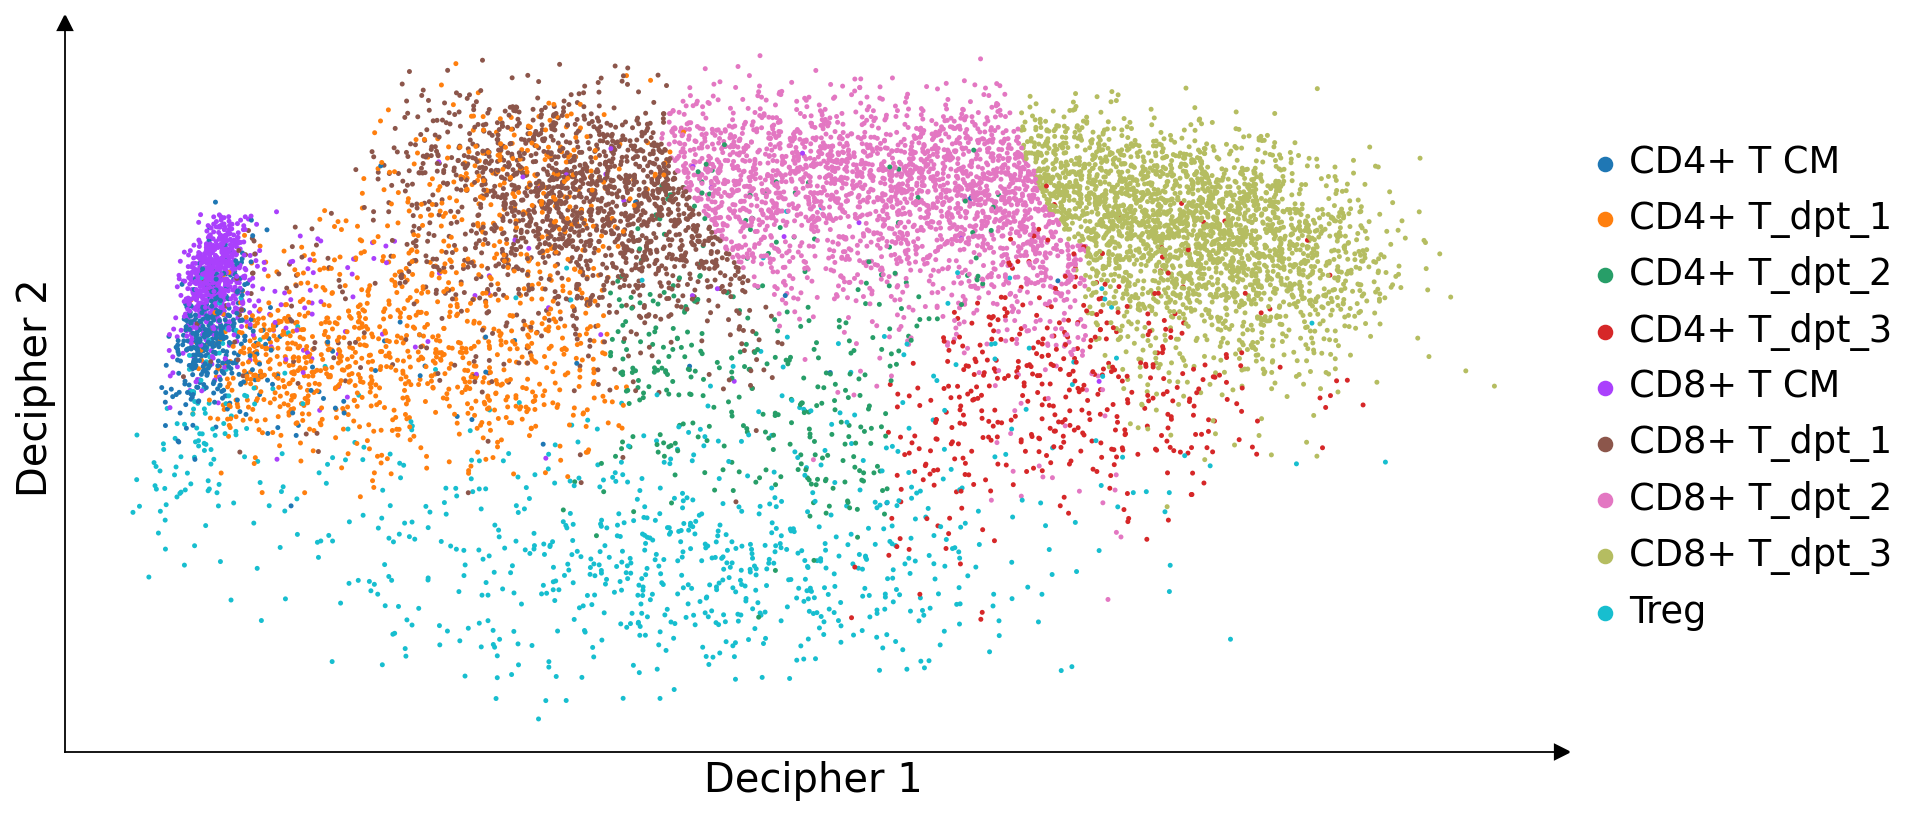

In [29]:
dc.pl.decipher(tcells, color = 'dpt_bucket', figsize=(12,6), s=20);

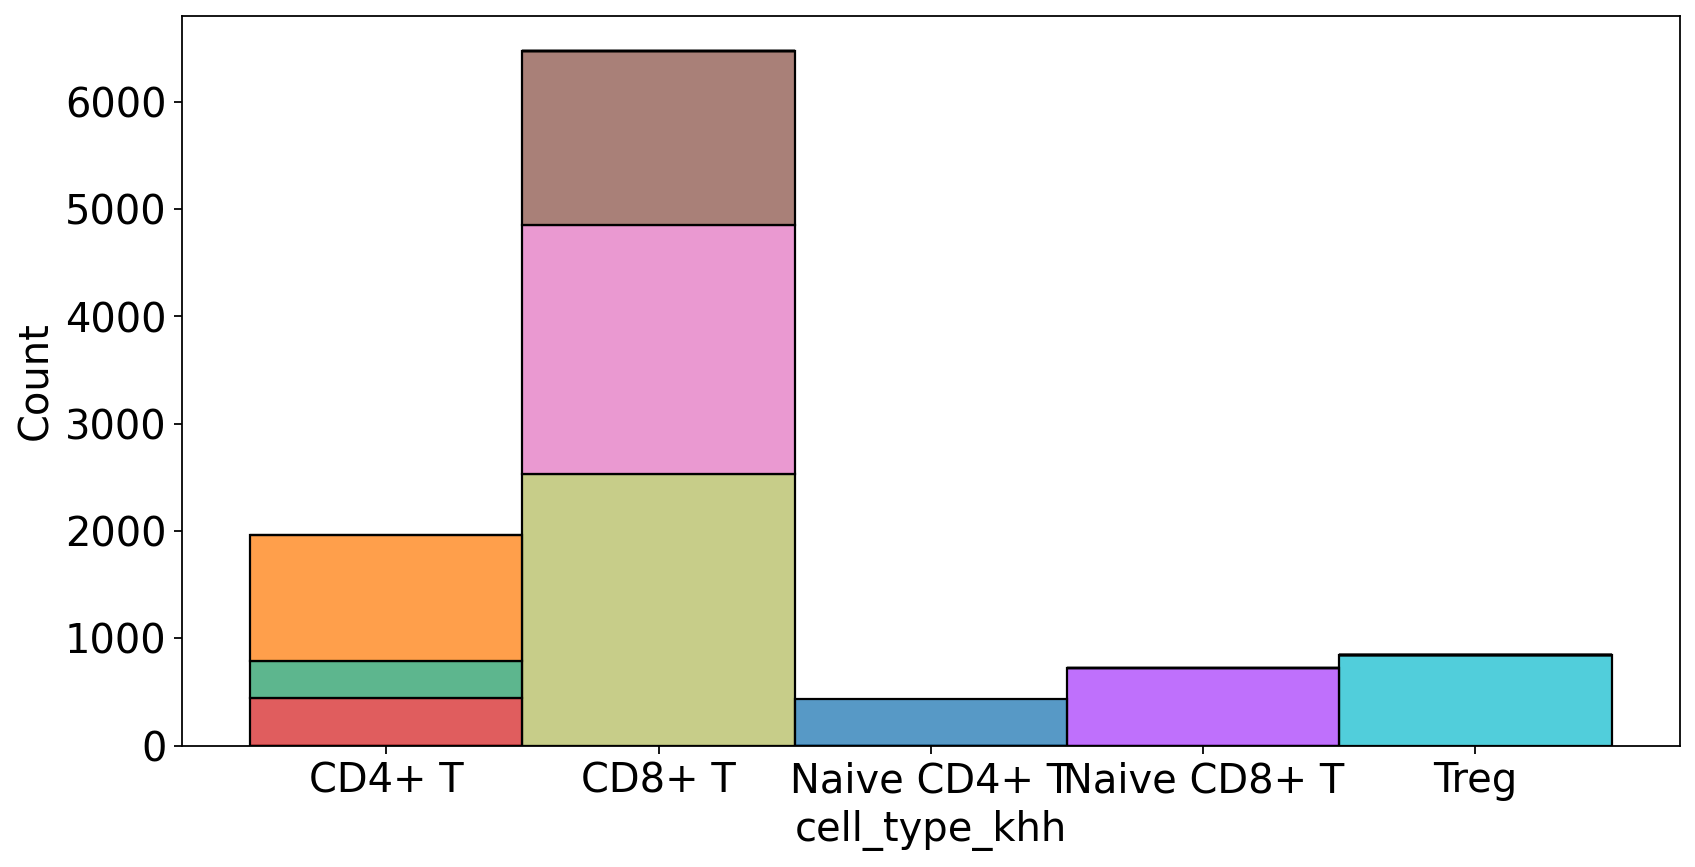

In [30]:
plt.subplots(figsize=(12,6))
sns.histplot(tcells.obs, x='cell_type_khh', hue='dpt_bucket', multiple='stack', legend=False);

In [31]:
tcells.obs['barcode_sample'] = tcells.obs['barcode_orig'].astype('str') + '_' + tcells.obs['sample'].astype('str')
tcells.obs['barcode_sample'] = tcells.obs['barcode_sample'].astype('category')
tcells.obs.index = tcells.obs['barcode_sample']

# annotate and feature select integrated dataset

In [32]:
adata.obs.index = adata.obs['barcode_sample']

In [33]:
# add clone status to tumors
adata.obs['clone_status'] = adata.obs['barcode_sample'].map(tumor_clones.obs['clone_status'].to_dict())
adata.obs['clone_status'] = adata.obs['clone_status'] + ' Tumor clones'
adata.obs.loc[adata.obs['clone_status'].isnull(),'clone_status'] = 'None'
adata.obs['clone_status'] = adata.obs['clone_status'].astype('category')

In [34]:
# add dpt buckets to T cells
adata.obs['dpt_bucket'] = adata.obs['barcode_sample'].map(tcells.obs['dpt_bucket'].to_dict())

In [35]:
# filter for only tumor clones and non-tumor data, if needed
adata_filtered = adata[~((adata.obs['clone_status']!='None') & (adata.obs['cell_type_main']!='Tumor cells'))]

In [36]:
hvgs = keep_interactions | tcells_genes | myeloids_genes | tumor_hvg_list
print(len(hvgs))

18303


In [37]:
adata_filtered.var['feature_selection'] = False
adata_filtered.var.loc[adata_filtered.var['features'].isin(hvgs),'feature_selection'] = True

In [38]:
# adata_filtered.raw = adata_filtered # saving for space

In [39]:
print(adata_filtered.shape)
adata_filtered = adata_filtered[:,adata_filtered.var['feature_selection']]
print(adata_filtered.shape)

(115019, 35675)
(115019, 18211)


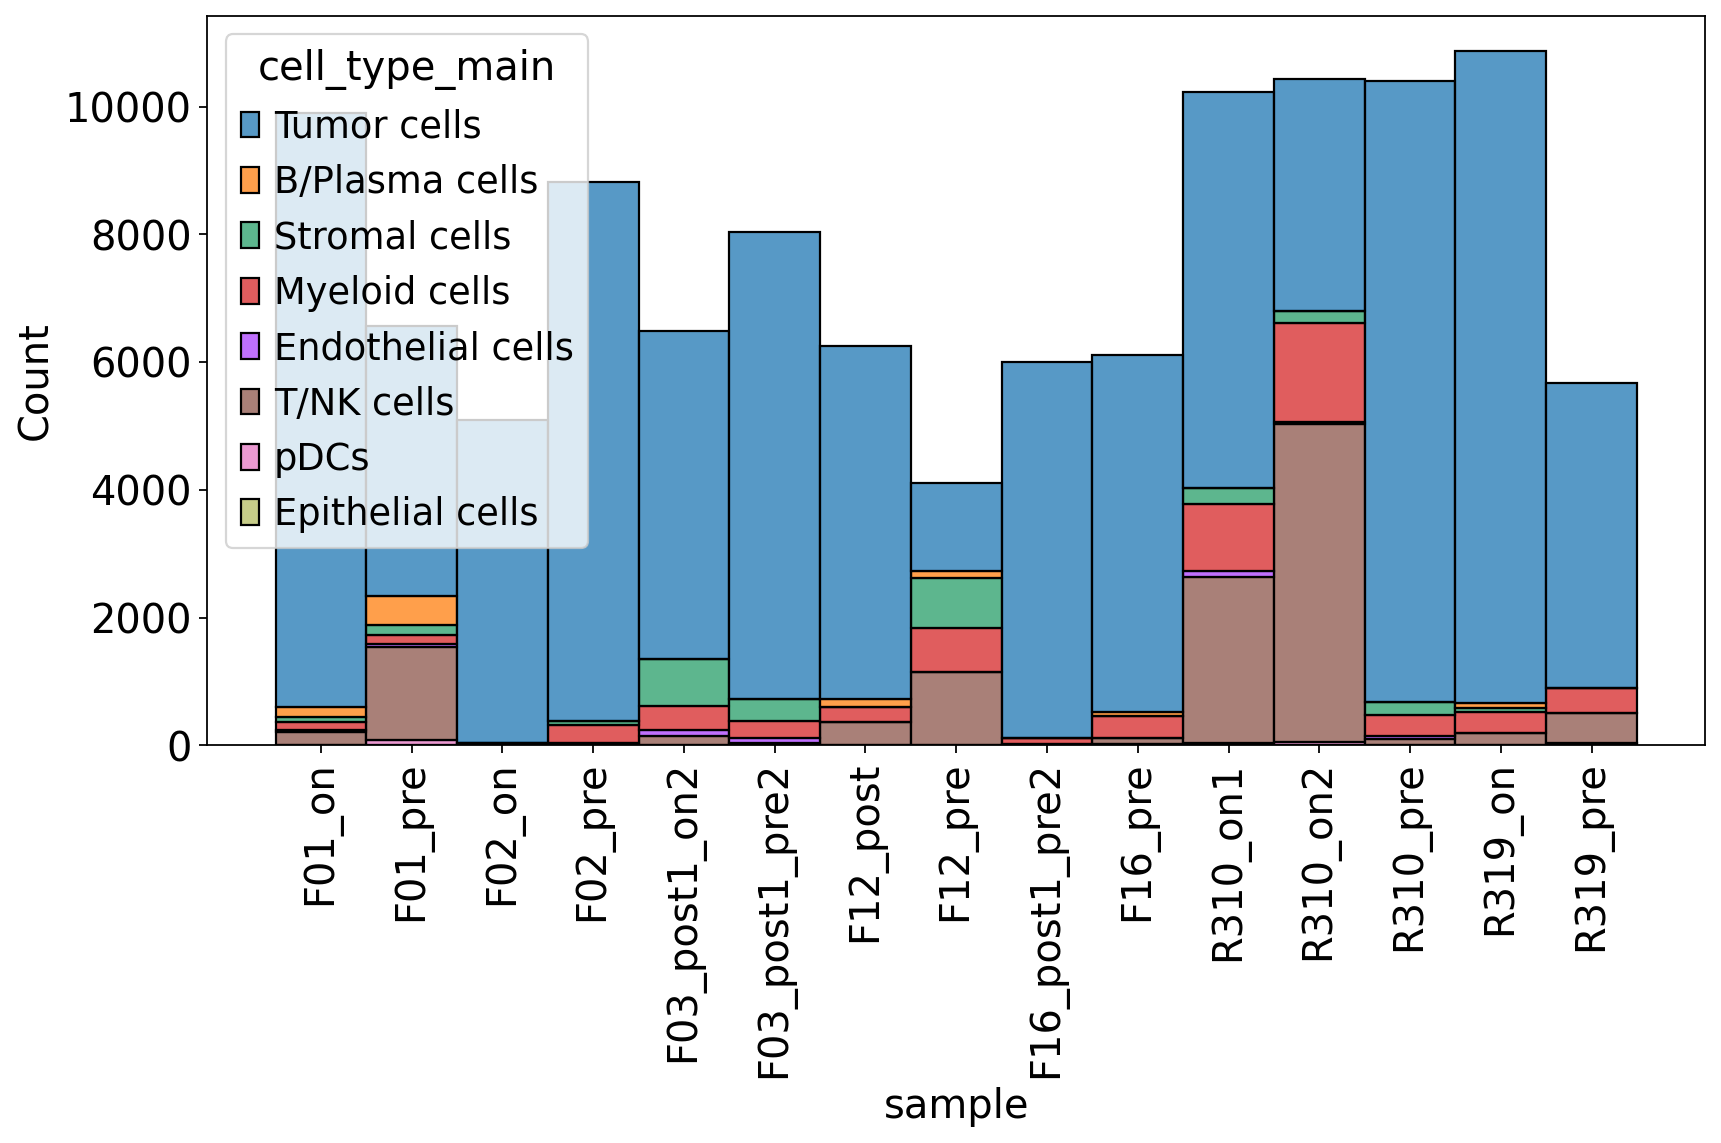

In [40]:
fig,ax=plt.subplots(figsize=(12,6))
sns.histplot(adata_filtered.obs, x='sample', hue='cell_type_main', multiple='stack')
plt.xticks(rotation=90);

In [ ]:
# run including clonal designations and decipher_time buckets will be called cell_type_ct_dpt
# use cell_type_main for non-tumor, -immune, and -myeloid cells
adata_filtered.obs['cell_type_ct_dpt'] = adata_filtered.obs['cell_type_main'].astype('str') # map coarse types
adata_filtered.obs.loc[adata_filtered.obs['cell_type_ct_dpt'] == 'Tumor cells','cell_type_ct_dpt'] = \
        adata_filtered.obs.loc[adata_filtered.obs['cell_type_ct_dpt'] == 'Tumor cells','clone_status']
adata_filtered.obs.loc[adata_filtered.obs['cell_type_ct_dpt'] == 'Myeloid cells','cell_type_ct_dpt'] = \
        adata_filtered.obs.loc[adata_filtered.obs['cell_type_ct_dpt'] == 'Myeloid cells','cell_type_fine']
adata_filtered.obs.loc[adata_filtered.obs['cell_type_ct_dpt'] == 'T/NK cells','cell_type_ct_dpt'] = \
        adata_filtered.obs.loc[adata_filtered.obs['cell_type_ct_dpt'] == 'T/NK cells','cell_type_fine']
adata_filtered.obs.loc[~adata_filtered.obs['dpt_bucket'].isnull(), 'cell_type_ct_dpt'] = \
        adata_filtered.obs.loc[~adata_filtered.obs['dpt_bucket'].isnull(), 'dpt_bucket']
adata_filtered.obs['cell_type_ct_dpt'] = adata_filtered.obs['cell_type_ct_dpt'].astype('category')

In [43]:
adata_filtered.obs['cell_type_ct_dpt'] = [x.replace(' ', '_').replace('/','_').replace('(', '').replace(')','').replace('#', '').replace('.','').replace('-','_').replace('+','') for x in adata_filtered.obs['cell_type_ct_dpt'].astype(str)]
adata_filtered.obs.loc[adata_filtered.obs['cell_type_ct_dpt'].isin(['NK_cells_1','NK_cells_2']),'cell_type_ct_dpt'] = 'NK_cells' # collapse NK cells

print('Removing cells with no label:', np.sum(adata_filtered.obs['cell_type_ct_dpt']==None))
adata_filtered = adata_filtered[adata_filtered.obs['cell_type_ct_dpt']!='None']

Removing cells with no label: 0


In [46]:
adata_filtered.write_h5ad('contact_tracing/ContactTracing_tutorial/data/contact_tracing_merged_080724.h5ad')

... storing 'orig.ident' as categorical
... storing 'sample' as categorical
... storing 'condition' as categorical
... storing 'barcode_orig' as categorical
... storing 'RNA_snn_res.0.8' as categorical
... storing 'clonotype_id' as categorical
... storing 'chain' as categorical
... storing 'v_gene' as categorical
... storing 'd_gene' as categorical
... storing 'j_gene' as categorical
... storing 'c_gene' as categorical
... storing 'cdr3s_aa' as categorical
... storing 'cdr3s_nt' as categorical
... storing 'inkt_evidence' as categorical
... storing 'mait_evidence' as categorical
... storing 'tcr' as categorical
... storing 'mait' as categorical
... storing 'inkt' as categorical
... storing 'both_chains' as categorical
... storing 'clone_size' as categorical
... storing 'mait_inkt' as categorical
... storing 'celltype_bped_main' as categorical
... storing 'celltype_bped_fine' as categorical
... storing 'celltype_hpca_main' as categorical
... storing 'celltype_hpca_fine' as categorical
..

# finalize T cell dpt buckets annotations

In [33]:
adata = sc.read_h5ad('contact_tracing/ContactTracing_tutorial/data/contact_tracing_merged_080724.h5ad')

### adjust buckets

For more even coverage across treated/untreated

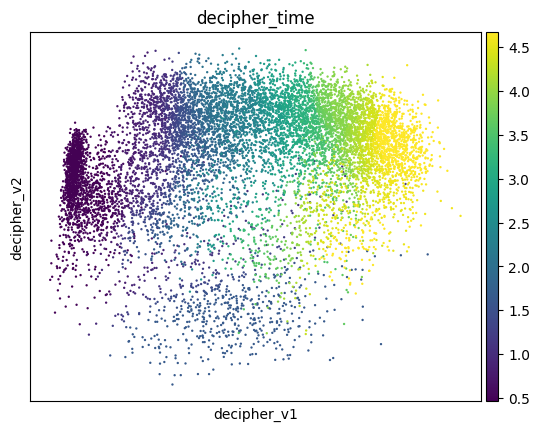

In [24]:
tcells = sc.read_h5ad('tcells_decipher_trajectories_091123.h5ad')
tcells.obs['cell_type_fine'] = tcells.obs['cell_type_khh']
tcells = tcells[tcells.obs['patient'].isin(patients),:]
sc.pl.embedding(tcells, basis='decipher_v', color = 'decipher_time');

In [25]:
tcells.obs['treated'] = tcells.obs['time'].replace({'on':'Treated','post':'Treated','pre':'Untreated'})

In [26]:
tcells.obs['cell_type_fine'] = tcells.obs['cell_type_fine'].replace({'Naive CD4+ T': 'CD4+ T CM', 'Naive CD8+ T': 'CD8+ T CM'})
tcells.obs['cell_type_fine'].unique()

['CD4+ T', 'Treg', 'CD8+ T CM', 'CD8+ T', 'CD4+ T CM']
Categories (5, object): ['CD4+ T', 'CD8+ T', 'CD4+ T CM', 'CD8+ T CM', 'Treg']

1.9
2.9


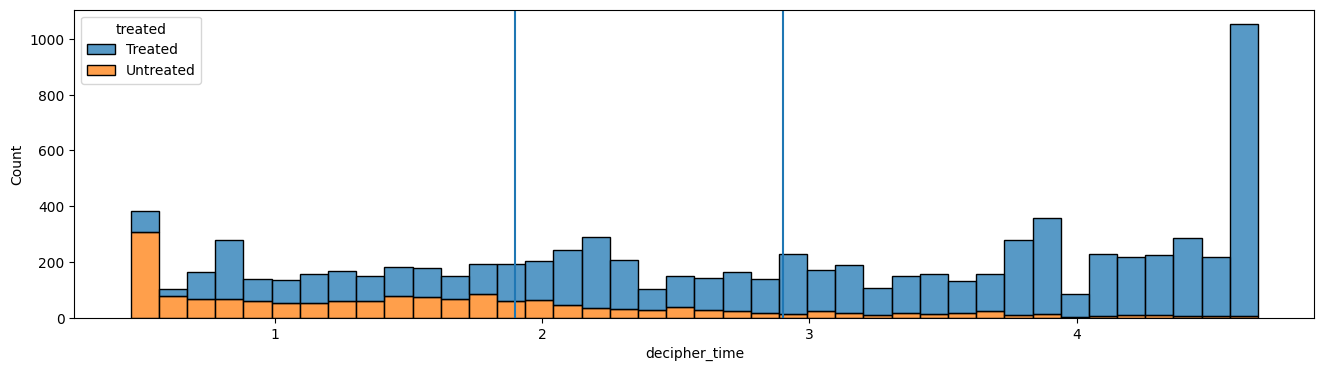

In [ ]:
# decide quantiles excluding Tcm and Treg
tcell_quantiles = [1.9,2.9]
fig,ax = plt.subplots(figsize=(16,4))
sns.histplot(dpt.obs, x='decipher_time', hue='treated', multiple='stack', bins=40);
for quantile in tcell_quantiles:
    print(quantile)
    plt.axvline(quantile, 0, 1200)

In [30]:
tcells.obs['dpt_bucket'] = str(1)
tcells.obs.loc[tcells.obs.decipher_time >= tcell_quantiles[0],'dpt_bucket'] = str(2)
tcells.obs.loc[tcells.obs.decipher_time >= tcell_quantiles[1],'dpt_bucket'] = str(3)
tcells.obs['dpt_bucket'] = tcells.obs['cell_type_fine'].astype('str') + '_dpt_' + tcells.obs['dpt_bucket'] # concatenate for CD8 and CD4
tcells.obs.loc[tcells.obs['cell_type_fine'].isin(['CD8+ T CM','CD4+ T CM','Treg']),'dpt_bucket'] = tcells.obs.loc[tcells.obs['cell_type_fine'].isin(['CD8+ T CM','CD4+ T CM','Treg']),'cell_type_fine'] # fix for Tcm and Treg
tcells.obs['dpt_bucket'] = pd.Categorical(tcells.obs['dpt_bucket'], # fix categories
        ['CD4+ T CM', 'CD4+ T_dpt_1','CD4+ T_dpt_2','CD4+ T_dpt_3',
         'CD8+ T CM', 'CD8+ T_dpt_1','CD8+ T_dpt_2','CD8+ T_dpt_3',
         'Treg'])

In [29]:
tcells.obs.groupby(['dpt_bucket', 'treated']).size()

dpt_bucket    treated  
CD4+ T CM     Treated        39
              Untreated     394
CD4+ T_dpt_1  Treated       446
              Untreated     661
CD4+ T_dpt_2  Treated       121
              Untreated     132
CD4+ T_dpt_3  Treated       550
              Untreated      51
CD8+ T CM     Treated        63
              Untreated     662
CD8+ T_dpt_1  Treated       921
              Untreated     462
CD8+ T_dpt_2  Treated      1326
              Untreated     222
CD8+ T_dpt_3  Treated      3405
              Untreated     142
Treg          Treated       525
              Untreated     319
dtype: int64

In [32]:
tcells.obs['barcode_sample'] = tcells.obs['barcode_orig'].astype('str') + '_' + tcells.obs['sample'].astype('str')
tcells.obs['barcode_sample'] = tcells.obs['barcode_sample'].astype('category')
tcells.obs.index = tcells.obs['barcode_sample']

In [34]:
# add dpt buckets to T cells
adata.obs['dpt_bucket'] = adata.obs['barcode_sample'].map(tcells.obs['dpt_bucket'].to_dict())

In [ ]:
adata.obs.groupby(['dpt_bucket', 'treated']).size()

In [36]:
adata.write_h5ad('contact_tracing/ContactTracing_tutorial/data/contact_tracing_merged_082224.h5ad')

# finalize clone and patient information annotation

In [6]:
adata = sc.read_h5ad('contact_tracing/ContactTracing_tutorial/data/contact_tracing_merged_082224.h5ad')

In [10]:
old_clones = adata[adata.obs['cell_type_ct_dpt'].isin([
    'growing_Tumor_clones',
    'shrinking_Tumor_clones',
    'stable_Tumor_clones',
])].obs.copy()

In [11]:
new_clone_status = pd.read_csv('cell_clone_status_data_corrected.csv')
new_clone_status['index'] = new_clone_status['index'] + '_' + new_clone_status['sample']
new_clone_status['echidna_status'] = new_clone_status['echidna_status'] + '_' + 'Tumor_clones'
new_clone_status.set_index('index', inplace=True)
new_clone_status.head()

,echidna_clones,echidna_status,sample
index,,,
AGATTGCGTTGGTTTG-1_F16_pre,C1,shrinking_Tumor_clones,F16_pre
TCGGGACGTTAAGACA-1_F16_pre,C1,shrinking_Tumor_clones,F16_pre
TGTGGTAGTACCGTTA-1_F16_pre,C1,shrinking_Tumor_clones,F16_pre
GTGTGCGTCCTCCTAG-1_F16_pre,C1,shrinking_Tumor_clones,F16_pre
TGGCTGGAGTAGCGGT-1_F16_pre,C1,shrinking_Tumor_clones,F16_pre


In [12]:
keep = list(set(old_clones.index) & set(new_clone_status.index)) # to simplify label transfer
remove = list(set(old_clones.index) - set(new_clone_status.index)) # remove any collisions

In [13]:
new_clone_status = new_clone_status.loc[keep,:]

In [14]:
adata.obs.loc[keep, 'cell_type_ct_dpt'] = new_clone_status.loc[keep,'echidna_status']

In [15]:
adata.shape

(106898, 18211)

In [16]:
adata = adata[~adata.obs.index.isin(remove),:]
print(adata.shape)

(106842, 18211)


In [9]:
adata.obs[['patient','treated','responder']].value_counts(sort=False)

patient  treated    responder    
F01      Treated    Non-responder     9758
         Untreated  Non-responder     6411
F02      Treated    Responder         5033
         Untreated  Responder         8578
F03      Treated    Non-responder    14298
F12      Treated    Non-responder     6171
         Untreated  Non-responder     4025
F16      Untreated  Responder        11642
R310     Treated    Responder        14406
         Untreated  Responder        10200
R319     Treated    Non-responder    16320
Name: count, dtype: int64

In [11]:
adata.obs['treated'] = adata.obs['sample'].replace(clinical_outcomes['treated'])
adata.obs['responder'] = adata.obs['sample'].replace(clinical_outcomes['responder'])

In [13]:
adata.write_h5ad('contact_tracing_merged_022625.h5ad')

# finalize myeloid cell annotations

In [8]:
adata = sc.read_h5ad('contact_tracing_merged_022625.h5ad')

In [9]:
adata.shape

(106842, 18211)

In [16]:
myeloid_reannotation = sc.read_h5ad('myeloid_scvi_annotated_032025.h5ad')
print(myeloid_reannotation.shape)

(18152, 2041)


In [13]:
adata.obs['cell_type_main'].value_counts(sort=False)

cell_type_main
B/Plasma cells         955
Endothelial cells      414
Epithelial cells        33
Myeloid cells         6235
Stromal cells         2880
T/NK cells           11841
Tumor cells          84229
pDCs                   255
Name: count, dtype: int64

In [15]:
print(adata.shape)
adata_nonmyeloid = adata[adata.obs['cell_type_main']!='Myeloid cells']
print(adata_nonmyeloid.shape)
adata_myeloid = adata[adata.obs['cell_type_main']=='Myeloid cells']
print(adata_myeloid.shape)

(106842, 18211)
(100607, 18211)
(6235, 18211)


In [29]:
myeloid_reannotation.obs['index'] = myeloid_reannotation.obs['barcode_orig'].astype('str') + "_" + myeloid_reannotation.obs['sample'].astype('str')
myeloid_reannotation.obs.index = myeloid_reannotation.obs['index']

In [31]:
keep = list(set(adata_myeloid.obs.index) & set(myeloid_reannotation.obs.index)) # to simplify label transfer
remove = list(set(adata_myeloid.obs.index) - set(myeloid_reannotation.obs.index)) # remove any collisions

In [35]:
adata_myeloid = adata_myeloid[keep,:]
myeloid_reannotation = myeloid_reannotation[keep,:]
print(adata_myeloid.shape)
print(myeloid_reannotation.shape)

(6211, 18211)
(6211, 2041)


In [37]:
adata_myeloid.obs['cell_type_fine'] = myeloid_reannotation.obs['cell_type_fine']
adata_myeloid.obs['cell_type_ct_dpt'] = myeloid_reannotation.obs['cell_type_fine']

In [38]:
adata = ad.concat([adata_nonmyeloid,adata_myeloid])
print(adata.shape)

(106818, 18211)


In [42]:
adata.obs['cell_type_main'].value_counts(sort=False)

cell_type_main
B/Plasma cells         955
Endothelial cells      414
Epithelial cells        33
Myeloid cells         6211
Stromal cells         2880
T/NK cells           11841
Tumor cells          84229
pDCs                   255
Name: count, dtype: int64

In [45]:
adata.write_h5ad('contact_tracing_merged_032125.h5ad')